In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dfply import *
import tensorflow_recommenders as tfrs

%matplotlib inline

In [2]:
df = pd.read_csv("./data/ratings_Electronics.csv", names=['userId', 'productId','rating','timestamp'])

In [3]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [5]:
print('The minimum rating is: %d' %(df['rating'].min()))
print('The maximum rating is: %d' %(df['rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


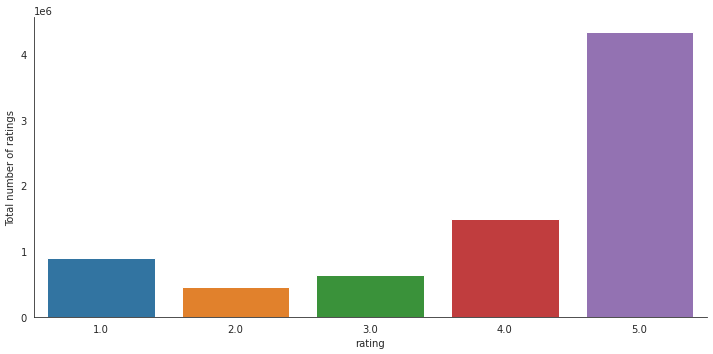

In [6]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [7]:
from datetime import datetime
start_date = datetime.fromtimestamp(df["timestamp"].min())
end_date = datetime.fromtimestamp(df["timestamp"].max())
print(f"start date: {start_date}.")
print(f"end date: {end_date}.")

start date: 1998-12-04 00:00:00.
end date: 2014-07-23 01:00:00.


In [8]:
df_sub = df >> mask(
    X.timestamp <= (X.timestamp.min() + X.timestamp.max())/2
)
df_after = df >> mask(
    X.timestamp > (X.timestamp.min() + X.timestamp.max())/2
)
df_sub.head()

,userId,productId,rating,timestamp
165,A2R4GEWPLORVSO,0899336795,2.0,1103328000
166,A1KKUYTDUZDZSA,0899336795,4.0,1104192000
170,A28K8QC9C4WPGE,0899336795,1.0,1141084800
171,A266DODBJYK0X,0899336795,1.0,1116806400
172,A17RBVZX3VTNBW,0899336795,1.0,1111449600


In [9]:
product_lst = (df_sub >> group_by(
    X.productId
) >> summarize(
    Count = n(X.userId)
) >> ungroup() >> arrange(
    X.Count
)>> mask(
    X.Count <=10
))['productId'].values

In [10]:
df_sub=(df_sub >> mask(
    ~X.productId.isin(product_lst)
))
df_sub.head()

,userId,productId,rating,timestamp
3936,A3DX16W5GTC0TL,6301977173,1.0,1122595200
3937,A2XM8ANEZJR4X7,6301977173,5.0,1094342400
3949,A30PMBDGB7VPAO,6301977173,4.0,1006905600
3952,A165PNFJ3X8AQF,6301977173,5.0,963792000
3955,A3UUK286EGZKEA,6301977173,4.0,1070150400


In [11]:
len(product_lst[product_lst=="6301977173"])

0

In [12]:
ds = tf.data.Dataset.from_tensor_slices(dict(df_sub))
ds

2021-10-25 09:28:14.145954: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TensorSliceDataset shapes: {userId: (), productId: (), rating: (), timestamp: ()}, types: {userId: tf.string, productId: tf.string, rating: tf.float64, timestamp: tf.int64}>

In [13]:
ratings = ds.map(lambda x: {
    "productId": x["productId"],
    "userId": x["userId"],
    "timestamp": x["timestamp"],
    "rating": x["rating"]
})
products = ds.map(lambda x: x["productId"])
products = products.unique()

In [14]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_product_ids = np.unique(np.concatenate(list(products.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["userId"]))))

2021-10-25 09:28:14.293748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
class UserModel(tf.keras.Model):

  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["userId"])

    return tf.concat([
        self.user_embedding(inputs["userId"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [16]:
class productModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    
    self.product_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_product_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_product_ids) + 1, 32)
    ])

  def call(self, product):
    return self.product_embedding(product)

In [17]:
class AmazonModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])

    self.candidate_model = tf.keras.Sequential([
      productModel(),
      tf.keras.layers.Dense(32)
    ])

    self.task= tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=products.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embeddings = self.query_model({
        "userId": features["userId"],
        "timestamp": features["timestamp"],
    })
    product_embeddings = self.candidate_model(features["productId"])

    return self.task(query_embeddings, product_embeddings)

In [18]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(100_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [20]:
model = AmazonModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3,verbose=0)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
5/5 [==============================] - 11s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.4866 - factorized_top_k/top_5_categorical_accuracy: 0.8277 - factorized_top_k/top_10_categorical_accuracy: 0.8629 - factorized_top_k/top_50_categorical_accuracy: 0.9233 - factorized_top_k/top_100_categorical_accuracy: 0.9477 - loss: 8783.9591 - regularization_loss: 0.0000e+00 - total_loss: 8783.9591
Top-100 accuracy (train): 0.94.
Top-100 accuracy (test): 0.95.


In [21]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)

index.index_from_dataset(
  tf.data.Dataset.zip((products.batch(100), products.batch(100).map(model.candidate_model)))
)

query = dict(pd.DataFrame({'userId': ["AGHZXQL9F94T9"],'timestamp':[1406073600]}).iloc[0].map(lambda x: tf.expand_dims(x,axis=0)))

# Get recommendations.
_, product = index(query)
print(f"Recommendations for user AGHZXQL9F94T9: {product[0, :5]}")

Consider rewriting this model with the Functional API.
Recommendations for user AGHZXQL9F94T9: [b'B0007YFQD0' b'B00092REF8' b'B00080QYRK' b'B0006698SS' b'B0007RB1WW']


In [22]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
])

product_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_product_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_product_ids) + 1, 32)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=products.batch(128).map(product_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [23]:
from typing import Dict, Text
class ProductRecModel(tfrs.Model):

  def __init__(self, user_model, product_model):
    super().__init__()
    self.product_model: tf.keras.Model = product_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["userId"])
    positive_product_embeddings = self.product_model(features["productId"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_product_embeddings)

In [24]:
model2 = ProductRecModel(user_model, product_model)
model2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [25]:
model2.fit(cached_train, epochs=3,verbose=0)

In [26]:
model2.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 11s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.2549 - factorized_top_k/top_5_categorical_accuracy: 0.5239 - factorized_top_k/top_10_categorical_accuracy: 0.5993 - factorized_top_k/top_50_categorical_accuracy: 0.8098 - factorized_top_k/top_100_categorical_accuracy: 0.9045 - loss: 25643.2572 - regularization_loss: 0.0000e+00 - total_loss: 25643.2572


{'factorized_top_k/top_1_categorical_accuracy': 0.25485000014305115,
 'factorized_top_k/top_5_categorical_accuracy': 0.5239499807357788,
 'factorized_top_k/top_10_categorical_accuracy': 0.5992500185966492,
 'factorized_top_k/top_50_categorical_accuracy': 0.8098000288009644,
 'factorized_top_k/top_100_categorical_accuracy': 0.9045000076293945,
 'loss': 23257.23046875,
 'regularization_loss': 0,
 'total_loss': 23257.23046875}

In [27]:
index = tfrs.layers.factorized_top_k.BruteForce(model2.user_model)

index.index_from_dataset(
  tf.data.Dataset.zip((products.batch(100), products.batch(100).map(model2.product_model)))
)

# Get recommendations.
_, product = index(tf.constant(["AGHZXQL9F94T9"]))
print(f"Recommendations for user AGHZXQL9F94T9: {product[0, :5]}")

Recommendations for user AGHZXQL9F94T9: [b'B0001A99MO' b'B0002OD3JY' b'B00005OQMO' b'B00066EK36' b'B0007Y79B2']


In [28]:
df >> mask(
    X.userId == "AGHZXQL9F94T9",
    X.timestamp > (X.timestamp.min() + X.timestamp.max())/2
    )

,userId,productId,rating,timestamp
748188,AGHZXQL9F94T9,B000BFNT0W,4.0,1222560000
825867,AGHZXQL9F94T9,B000DZTDAK,1.0,1222560000
1060686,AGHZXQL9F94T9,B000IVL3DE,5.0,1222560000
1602410,AGHZXQL9F94T9,B0012GQZZU,4.0,1221609600
1682633,AGHZXQL9F94T9,B0014IYZDK,2.0,1234310400


In [29]:
df_sub.head()

,userId,productId,rating,timestamp
3936,A3DX16W5GTC0TL,6301977173,1.0,1122595200
3937,A2XM8ANEZJR4X7,6301977173,5.0,1094342400
3949,A30PMBDGB7VPAO,6301977173,4.0,1006905600
3952,A165PNFJ3X8AQF,6301977173,5.0,963792000
3955,A3UUK286EGZKEA,6301977173,4.0,1070150400


In [30]:
mu = df_sub['rating'].mean()

In [31]:
df_sub['y_hat'] = mu

In [32]:
df_sub.head()

,userId,productId,rating,timestamp,y_hat
3936,A3DX16W5GTC0TL,6301977173,1.0,1122595200,3.741593
3937,A2XM8ANEZJR4X7,6301977173,5.0,1094342400,3.741593
3949,A30PMBDGB7VPAO,6301977173,4.0,1006905600,3.741593
3952,A165PNFJ3X8AQF,6301977173,5.0,963792000,3.741593
3955,A3UUK286EGZKEA,6301977173,4.0,1070150400,3.741593


Naive Ranking

In [33]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_sub['rating'].values, df_sub['y_hat'].values, squared=False)

1.4871675515023781

In [34]:
product_effect = df_sub >> group_by(
    X.productId
) >> summarize(
    b_prod = (X.rating - mu).mean()
)

In [35]:
df_sub = df_sub.merge(product_effect,left_on='productId',right_on='productId')

In [36]:
df_sub.head()

,userId,productId,rating,timestamp,y_hat,b_prod
0,A3DX16W5GTC0TL,6301977173,1.0,1122595200,3.741593,-0.832502
1,A2XM8ANEZJR4X7,6301977173,5.0,1094342400,3.741593,-0.832502
2,A30PMBDGB7VPAO,6301977173,4.0,1006905600,3.741593,-0.832502
3,A165PNFJ3X8AQF,6301977173,5.0,963792000,3.741593,-0.832502
4,A3UUK286EGZKEA,6301977173,4.0,1070150400,3.741593,-0.832502


In [37]:
mean_squared_error(df_sub['rating'].values, (df_sub['y_hat'].values + df_sub['b_prod'].values), squared=False)

1.335921620622961

In [38]:
user_effect = df_sub >> group_by(
    X.userId
) >> summarize(
    b_user = (X.rating - mu - X.b_prod).mean()
)

In [39]:
df_sub = df_sub.merge(user_effect,left_on='userId',right_on='userId')

In [40]:
df_sub.head()

,userId,productId,rating,timestamp,y_hat,b_prod,b_user
0,A3DX16W5GTC0TL,6301977173,1.0,1122595200,3.741593,-0.832502,-1.909091
1,A2XM8ANEZJR4X7,6301977173,5.0,1094342400,3.741593,-0.832502,2.090909
2,A30PMBDGB7VPAO,6301977173,4.0,1006905600,3.741593,-0.832502,1.090909
3,A165PNFJ3X8AQF,6301977173,5.0,963792000,3.741593,-0.832502,2.090909
4,A3UUK286EGZKEA,6301977173,4.0,1070150400,3.741593,-0.832502,1.090909


In [41]:
mean_squared_error(df_sub['rating'].values, (df_sub['y_hat'].values + df_sub['b_prod'].values + df_sub['b_user'].values), squared=False)

0.4884544087955891

In [42]:
test_user = "AGHZXQL9F94T9"
test_product = "B00002EQD2"

In [43]:
b_u = user_effect[user_effect['userId']==test_user]['b_user'].values
b_p = product_effect[product_effect['productId']==test_product]['b_prod'].values

In [44]:
test_rating = mu + b_u + b_p
print(test_rating)

[1.92338528]


In [45]:
def predict_rating(user,product):
    b_u = user_effect[user_effect['userId']==user]['b_user'].values
    b_p = product_effect[product_effect['productId']==product]['b_prod'].values
    test_rating = mu + b_u + b_p
    return print(test_rating)

In [46]:
predict_rating("AGHZXQL9F94T9","B00002EQD2")

[1.92338528]


In [47]:
(df_sub >> mask(
    X.userId == "AGHZXQL9F94T9"    
)).head(10)

,userId,productId,rating,timestamp,y_hat,b_prod,b_user
9814,AGHZXQL9F94T9,B00002EQD2,5.0,1017187200,3.741593,-1.574926,-0.243281
9815,AGHZXQL9F94T9,B00004XRED,5.0,1055635200,3.741593,0.751161,-0.243281
9816,AGHZXQL9F94T9,B00005ICE3,5.0,1013817600,3.741593,1.031134,-0.243281
9817,AGHZXQL9F94T9,B00005NVPW,2.0,1021507200,3.741593,0.493701,-0.243281
9818,AGHZXQL9F94T9,B00005OQMO,5.0,1006214400,3.741593,0.560131,-0.243281
9819,AGHZXQL9F94T9,B0000630TO,5.0,1052611200,3.741593,0.094771,-0.243281
9820,AGHZXQL9F94T9,B000063BGY,2.0,1022371200,3.741593,0.038407,-0.243281
9821,AGHZXQL9F94T9,B0000645C8,5.0,1021507200,3.741593,0.893328,-0.243281
9822,AGHZXQL9F94T9,B0000645C9,2.0,1020556800,3.741593,0.745364,-0.243281
9823,AGHZXQL9F94T9,B000065UTC,4.0,1059436800,3.741593,-0.196138,-0.243281


In [48]:
(df_sub >> mask(
    X.productId == "B00002EQD2"    
)).head(10)

,userId,productId,rating,timestamp,y_hat,b_prod,b_user
9801,A33TOTDUVWTCT7,B00002EQD2,5.0,963187200,3.741593,-1.574926,2.833333
9802,A24P4XOBMMD9IO,B00002EQD2,1.0,1005696000,3.741593,-1.574926,-0.325665
9804,A1LH6RF4UN9VI6,B00002EQD2,5.0,963446400,3.741593,-1.574926,0.376667
9806,A2NJG3ODZIN3PF,B00002EQD2,1.0,998956800,3.741593,-1.574926,-1.423743
9808,A33Z5QC2H4LO42,B00002EQD2,1.0,971049600,3.741593,-1.574926,-1.166667
9809,AW83S74Y4GEAU,B00002EQD2,1.0,991699200,3.741593,-1.574926,-1.166667
9810,AKOR6A8V9CT05,B00002EQD2,1.0,962236800,3.741593,-1.574926,-1.166667
9811,A3BUIU8HYGG79Y,B00002EQD2,1.0,999475200,3.741593,-1.574926,-1.166667
9812,A1W7B29AV4RJWN,B00002EQD2,1.0,991008000,3.741593,-1.574926,-1.166667
9813,A2W2KKKUJON11Y,B00002EQD2,2.0,964915200,3.741593,-1.574926,-0.166667


In [49]:
l_reg = np.arange(-0.2, 0.3, 0.1,)
l_reg   

array([-0.2, -0.1,  0. ,  0.1,  0.2])

In [50]:
rmse = []
for l in l_reg:
    product_effect_reg = df_sub  >> mutate(Reg = l) >> group_by(
    X.productId) >> summarize(
    b_prod_reg = (X.rating - X.y_hat).sum()/(X.Reg.mean()+n(X.productId))
    )

    df_sub_reg = df_sub.merge(product_effect_reg,left_on='productId',right_on='productId')

    user_effect_reg = df_sub_reg >> mutate(Reg = l) >> group_by(
    X.userId) >> summarize(
    b_user_reg = (X.rating - X.y_hat - X.b_prod_reg).sum()/(X.Reg.mean()+n(X.userId))
    )

    df_sub_reg = df_sub_reg.merge(user_effect_reg,left_on='userId',right_on='userId')

    rmse.append(mean_squared_error(df_sub_reg['rating'], (df_sub_reg['y_hat'] + df_sub_reg['b_prod_reg'] + df_sub_reg['b_user_reg']), squared=False))

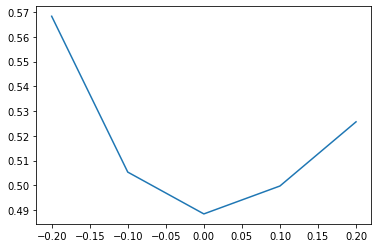

In [51]:
plt.plot(l_reg,np.asarray(rmse))
plt.show()